# **Detectron2**



`Detectron2 is an open-source platform developed by Facebook AI Research (FAIR) for solving computer vision tasks. It provides tools to build, train, and use models that can recognize and analyze objects in images and videos.`

**`Key Points:`**

`Object Detection: Detectron2 can detect and label multiple objects in an image, such as cars, people, or animals.`


`Instance Segmentation: Beyond detecting objects, it can outline the shape of each one, offering more detail than a simple bounding box.`


`Keypoint Detection: Detectron2 can identify specific points on objects, like human body joints (e.g., elbows, knees), which is useful for tasks like pose estimation.`

# **`1. Cloning the Detectron2 Repository and Installing Dependencies`**

`We clone the repository for Detectron2, ensuring all source files are available.`

`A specific version of PyYAML is installed, as it is a key dependency.`

`The setup script gathers all additional dependencies required for Detectron2, and these are installed automatically`









In [4]:
# Clone the Detectron2 repository
!git clone https://github.com/facebookresearch/detectron2.git


# Install PyYAML version 5.1
!python -m pip install pyyaml==5.1

# Run setup.py to gather install_requires
import sys, os, distutils.core
dist = distutils.core.run_setup("./detectron2/setup.py")

# Install required dependencies
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}

# Add Detectron2 to sys.path
sys.path.insert(0, os.path.abspath('./detectron2'))


fatal: destination path 'detectron2' already exists and is not an empty directory.
  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (

# **`2. Downloading and Preparing the Dataset`**

In [5]:
# Install wget for downloading the dataset
! pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=6ab1ce64b5ec746b795e62b537b4f6f7b24f854399fdf8a68e125033cf1b5e92
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [6]:
# Download and unzip the balloon dataset, which will be used for training the model
import wget
wget.download('https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip')

'balloon_dataset.zip'

In [7]:
# Extract the contents of the downloaded dataset
import zipfile
with zipfile.ZipFile("balloon_dataset.zip","r") as zip_ref:
    zip_ref.extractall("balloon_dataset")

# **`3. Setting Up Detectron2 and Required Libraries`**

In [8]:
# Import Detectron2 components for training and configuration
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger

# Set up the logger to capture detailed output from Detectron2
setup_logger()

# Import common libraries and utilities for image handling and JSON processing
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# Import Detectron2 utilities for prediction and visualization
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# **`4. Function for Displaying Images`**

In [10]:
import matplotlib.pyplot as plt
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

# **`5. Dataset Preparation: Parsing the Balloon Dataset Annotations`**

In [11]:
# Define a function to parse the dataset annotations and prepare them for Detectron2
def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts





for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon_dataset/balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])

balloon_metadata = MetadataCatalog.get("balloon_train")

`The function get_balloon_dicts() reads image annotations from a JSON file and formats them into a structure Detectron2 can use.`

`Each image’s filename, dimensions, and bounding box annotations are parsed and stored`

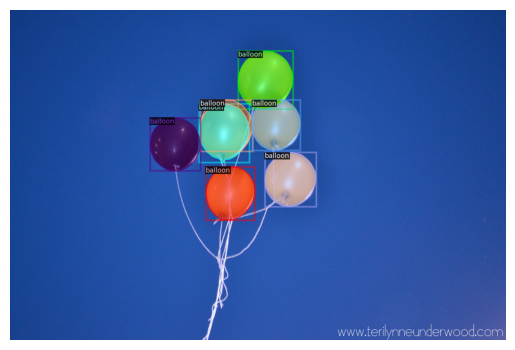

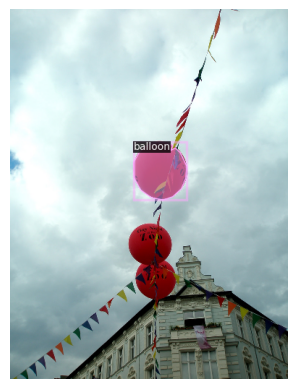

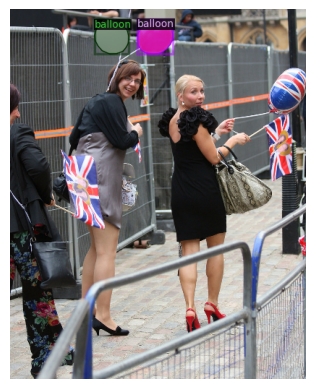

In [12]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

import matplotlib.pyplot as plt
dataset_dicts = get_balloon_dicts("balloon_dataset/balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

For Training:


# **`6. Configuring and Training the Mask R-CNN Model`**

In [14]:
from detectron2.engine import DefaultTrainer
# Create a Detectron2 configuration object
cfg = get_cfg()

# Load a predefined configuration from the Detectron2 model zoo (Mask R-CNN)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Modify configuration for balloon dataset training
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (balloon)

# Create output directory and initialize trainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[09/30 07:44:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/30 07:44:25 d2.engine.train_loop]: Starting training from iteration 0
[09/30 07:44:40 d2.utils.events]:  eta: 0:02:09  iter: 19  total_loss: 2.014  loss_cls: 0.6517  loss_box_reg: 0.6248  loss_mask: 0.6845  loss_rpn_cls: 0.03208  loss_rpn_loc: 0.007065    time: 0.4570  last_time: 0.4584  data_time: 0.0368  last_data_time: 0.0050   lr: 1.6068e-05  max_mem: 2461M
[09/30 07:44:49 d2.utils.events]:  eta: 0:01:59  iter: 39  total_loss: 1.829  loss_cls: 0.5696  loss_box_reg: 0.5697  loss_mask: 0.6015  loss_rpn_cls: 0.02538  loss_rpn_loc: 0.01002    time: 0.4628  last_time: 0.4851  data_time: 0.0177  last_data_time: 0.0141   lr: 3.2718e-05  max_mem: 2478M
[09/30 07:44:59 d2.utils.events]:  eta: 0:01:49  iter: 59  total_loss: 1.579  loss_cls: 0.4558  loss_box_reg: 0.6334  loss_mask: 0.4663  loss_rpn_cls: 0.0301  loss_rpn_loc: 0.006061    time: 0.4635  last_time: 0.6738  data_time: 0.0203  last_data_time: 0.0308   lr: 4.9367e-05  max_mem: 2478M
[09/30 07:45:07 d2.utils.events]:  eta: 0:01:3

# **`7. Inference with Trained Model`**

In [15]:
# Load the trained weights for inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Set a custom threshold for model predictions
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

# Initialize the predictor using the trained model and configuration
predictor = DefaultPredictor(cfg)


[09/30 07:47:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

# **`8. Visualizing Predictions`**

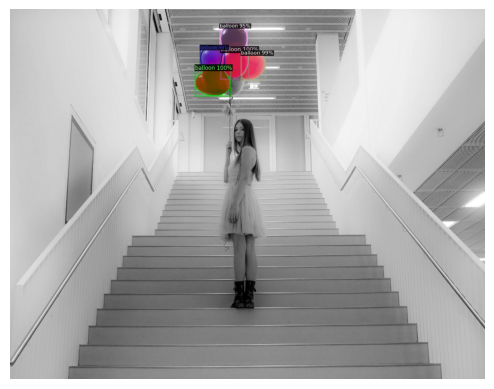

In [16]:
# Visualize model predictions on random samples from the validation set
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon_dataset/balloon/val")
for d in random.sample(dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # Run inference on the image
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
